# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 41.70 MiB/s, done.
Resolving deltas: 100% (3/3), done.


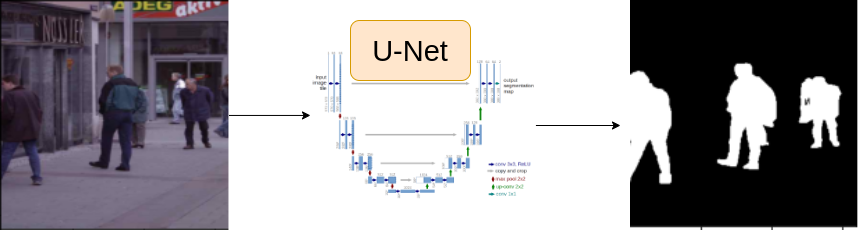

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/Human-Segmentation-Dataset-master/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 256

ENCODER = 'resnet18'
WEIGHTS = 'imagenet'
BATCH_SIZE = 16

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[5]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, 0) /255.0

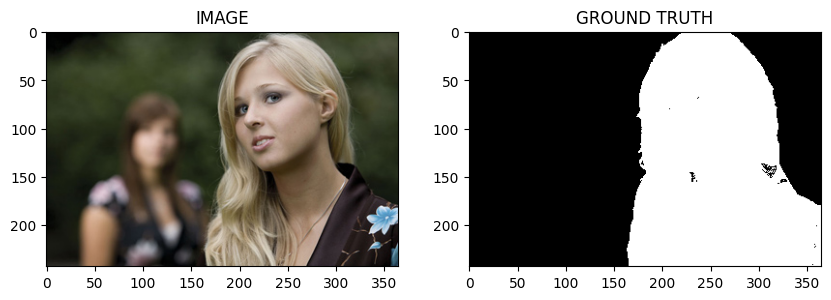

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
#splitting into train and test data
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
#using albumentation for augmentation. does the same augmentation to the image and mask
def get_train_augs():
  train_augs = A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])
  return train_augs

def get_valid_augs():
  valid_augs = A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])
  return valid_augs

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
#creating a segmentation dataset class
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, ind):
    row = self.df.iloc[ind]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)

      image = data['image']
      mask = data['mask']

    #making image as (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Add channel dimension to mask → (1, H, W)
    mask = np.expand_dims(mask, axis=0).astype(np.float32)

    #converting it to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.Tensor(mask) / 255.0


    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


# Task 5 : Load dataset into batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
for image, mask in trainloader:
  break

print(f'Image size : {image.shape}')
print(f'Mask size : {mask.shape}')

Image size : torch.Size([2, 3, 256, 256])
Mask size : torch.Size([2, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
#Encoder = efficientnet
#model = Unet
# Segmentation loss = DICE Loss
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.archi = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.archi(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, (loss1 + loss2).mean()
    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (archi): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in data_loader:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.train()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf
for epoch in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  torch.cuda.empty_cache()

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Model Saved')
    best_valid_loss = valid_loss
  print(f'Epoch : {epoch}/{EPOCHS}')

100%|██████████| 29/29 [00:00<00:00, 46.26it/s]


Model Saved
Epoch : 0/25


100%|██████████| 29/29 [00:00<00:00, 54.56it/s]


Model Saved
Epoch : 1/25


100%|██████████| 29/29 [00:00<00:00, 52.85it/s]


Epoch : 2/25


100%|██████████| 29/29 [00:00<00:00, 55.73it/s]


Model Saved
Epoch : 3/25


100%|██████████| 29/29 [00:00<00:00, 54.72it/s]


Epoch : 4/25


100%|██████████| 29/29 [00:00<00:00, 55.00it/s]


Model Saved
Epoch : 5/25


100%|██████████| 29/29 [00:00<00:00, 55.87it/s]


Model Saved
Epoch : 6/25


100%|██████████| 29/29 [00:00<00:00, 50.96it/s]


Epoch : 7/25


100%|██████████| 29/29 [00:00<00:00, 54.99it/s]


Epoch : 8/25


100%|██████████| 29/29 [00:00<00:00, 56.13it/s]


Epoch : 9/25


100%|██████████| 29/29 [00:00<00:00, 55.62it/s]


Model Saved
Epoch : 10/25


100%|██████████| 29/29 [00:00<00:00, 55.83it/s]


Epoch : 11/25


100%|██████████| 29/29 [00:00<00:00, 54.61it/s]


Model Saved
Epoch : 12/25


100%|██████████| 29/29 [00:00<00:00, 54.30it/s]


Model Saved
Epoch : 13/25


100%|██████████| 29/29 [00:00<00:00, 41.80it/s]


Epoch : 14/25


100%|██████████| 29/29 [00:00<00:00, 53.54it/s]


Epoch : 15/25


100%|██████████| 29/29 [00:00<00:00, 54.14it/s]


Model Saved
Epoch : 16/25


100%|██████████| 29/29 [00:00<00:00, 53.34it/s]


Epoch : 17/25


100%|██████████| 29/29 [00:00<00:00, 53.72it/s]


Epoch : 18/25


100%|██████████| 29/29 [00:00<00:00, 45.43it/s]


Epoch : 19/25


100%|██████████| 29/29 [00:00<00:00, 54.15it/s]


Epoch : 20/25


100%|██████████| 29/29 [00:00<00:00, 51.82it/s]


Epoch : 21/25


100%|██████████| 29/29 [00:00<00:00, 52.61it/s]


Model Saved
Epoch : 22/25


100%|██████████| 29/29 [00:00<00:00, 54.25it/s]


Model Saved
Epoch : 23/25


100%|██████████| 29/29 [00:00<00:00, 55.63it/s]

Epoch : 24/25


# Task 9 : Inference

In [ ]:
idx = 15

model.load_state_dict(torch.load('/content/best_model.pt'))
model.to(DEVICE)  # Ensure model is on the correct device
model.eval()  # Set model to evaluation mode


image, mask = validset[idx]

image = image.unsqueeze(0).to(DEVICE)
logits_mask = model(image)
pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-42-9686772d4759>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


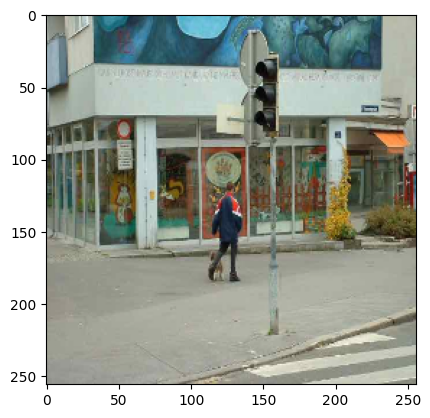

In [ ]:
plt.imshow(image.squeeze(0).permute(1,2,0).cpu())

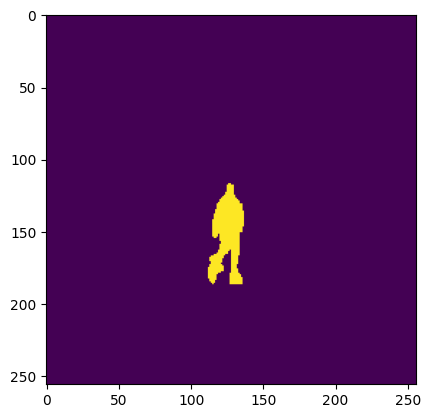

In [ ]:
plt.imshow(mask.squeeze(0).cpu())

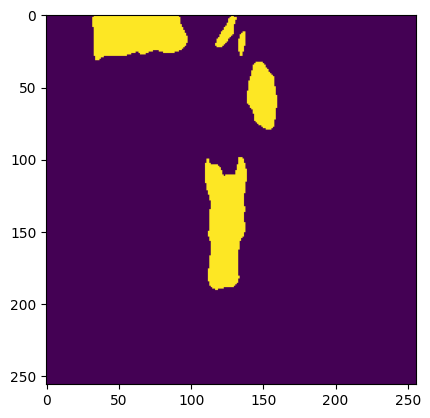

In [ ]:
plt.imshow(pred_mask.squeeze(0).permute(1,2,0).cpu())